In [1]:
import os, sys
import attr
# add to path
sys.path.append("../..")

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from PIL import Image
seaborn.set()

In [2]:

from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard.systematic import SystematicResampler
from filterflow.resampling.standard.multinomial import MultinomialResampler
from filterflow.resampling.differentiable.biased import RegularisedTransform

from filterflow.resampling.base import NoResampling


from filterflow.state_space_model import StateSpaceModel

In [3]:
observation_dim = 2
state_dim = 2
T = 150
initial_state          = np.repeat(0., state_dim)
transition_matrix      = np.eye(state_dim) * 0.5
transition_covariance  = np.eye(state_dim) * 0.5

observation_matrix     = np.eye(observation_dim) *0.5
observation_covariance = np.eye(observation_dim)*0.1

In [4]:
tf_observation_matrix = tf.constant(observation_matrix, dtype = tf.float32)
tf_observation_covariance = tf.constant(observation_covariance, dtype = tf.float32)


tf_transition_matrix = tf.constant(transition_matrix, dtype = tf.float32)
tf_transition_covariance =  tf.constant(transition_covariance, dtype = tf.float32)

In [5]:
# Transition
state_dim = tf_transition_covariance.shape.as_list()[0]
transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                                    tf_transition_covariance)

transition_model = RandomWalkModel(tf_transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                             tf_observation_covariance)
observation_model = LinearObservationSampler(tf_observation_matrix, observation_error)

In [6]:
## State space model
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
initial_particle = tf.constant(np.random.random(state_dim), dtype = tf.float32)
states, observations = ss_model(initial_particle, T)

In [7]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])

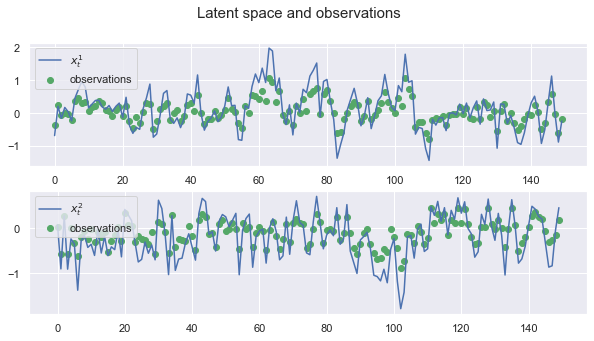

In [8]:
linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [9]:
# store observations
batch_size = 10
n_particles = 50
dimension = 2

resampling_criterion = NeffCriterion(0.5, is_relative=True)
resampling_method = RegularisedTransform(0.1, convergence_threshold=1e-3, scaling=0.8)
resampling_method = SystematicResampler()

weights = tf.ones((batch_size, n_particles), dtype=float)/tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros((batch_size), dtype=float)
initial_state = State(particles=initial_particles, log_weights= tf.math.log(weights), weights=weights, log_likelihoods=log_likelihoods)



In [10]:
observations_list = observations

In [11]:
obs_data = tf.data.Dataset.from_tensor_slices(observations_list)

In [12]:
init_g_matrix = 0.1 * np.eye(2)
init_g_cov = 0.5 * np.eye(2)

init_f_matrix = np.eye(2)
init_f_cov = 0.5 * np.eye(2)

g_matrix = tf.constant(init_g_matrix, dtype = tf.float32)
g_covariance = tf.constant(init_g_cov, dtype = tf.float32)


f_matrix = tf.constant(init_f_matrix, dtype = tf.float32)
f_covariance =  tf.Variable(init_f_cov, dtype = tf.float32,  trainable=True)

# Create an optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.1)


# transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., 2), dtype=tf.float32), 
#                                                                 f_covariance)
# transition_model = RandomWalkModel(f_matrix, transition_noise)

# # Observation
# observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., 2), dtype=tf.float32), 
#                                                          g_covariance)
# observation_model = LinearObservationSampler(g_matrix, observation_error)

# # proposal
# proposal_model = BootstrapProposalModel(transition_model)

# # particle filter
# particle_filter = SMC(observation_model, transition_model, 
#                                           proposal_model, resampling_criterion, resampling_method)
        
        

In [13]:
def make_filter(f_covariance):
    transition_noise = tfd.MultivariateNormalTriL(tf.zeros(2, dtype=tf.float32), f_covariance)
    transition_model = RandomWalkModel(tf_transition_matrix, transition_noise)

    observation_error = tfp.distributions.MultivariateNormalFullCovariance(tf.zeros(2, dtype=tf.float32), tf_observation_covariance)
    observation_model = LinearObservationSampler(tf_observation_matrix, observation_error)
    # proposal
    proposal_model = BootstrapProposalModel(transition_model)

    return SMC(observation_model, transition_model, proposal_model, resampling_criterion, resampling_method)

In [14]:
tf_observation_covariance

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.1, 0. ],
       [0. , 0.1]], dtype=float32)>

In [15]:
smc = make_filter(f_covariance)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [16]:
observation_series = tf.data.Dataset.from_tensor_slices(observations_list)

In [17]:
@tf.function
def loss_func():
    final_state = smc(initial_state, observation_series=observation_series, n_observations=len(observations_list), return_final = True)
    return tf.reduce_mean(-final_state.log_likelihoods / T)

In [18]:
initial_state.particles.numpy()[0].std(0)

array([0.5774333, 0.5797066], dtype=float32)

In [19]:
import pykalman
kf = pykalman.KalmanFilter(f_matrix.numpy(), g_matrix.numpy(), f_covariance.numpy(), g_covariance.numpy(), initial_state_mean=[0., 0.], initial_state_covariance=np.eye(2)*initial_state.particles.numpy().std())

In [23]:
em_kf = kf.em([k.numpy().squeeze() for k in observations_list])

In [24]:
em_kf.transition_covariance

array([[ 0.84298547, -0.26550665],
       [-0.26550665,  0.35575217]])

In [25]:
em_kf.observation_covariance

array([[0.07635109, 0.00084364],
       [0.00084364, 0.05804744]])

In [26]:
em_kf.transition_matrices

array([[1., 0.],
       [0., 1.]], dtype=float32)

In [20]:
@tf.function
def train_one_step(optimizer):
    var_list= [f_covariance]
    with tf.GradientTape() as tape:
        tape.watch(var_list)
        loss = loss_func()
    grads = tape.gradient(loss, var_list)
    optimizer.apply_gradients(zip(grads,var_list))

    return loss, grads

@tf.function
def train(optimizer, num_steps = 10):
    for step in tf.range(num_steps):
        loss, grads = train_one_step(optimizer)
        if step % (num_steps // 10) == 0:
            tf.print('Step', step, ': loss', loss)
            tf.print('grad', grads)
            tf.print('f_covariance', f_covariance @ tf.transpose(f_covariance))
            tf.print('')
    return f_matrix, f_covariance, g_matrix, g_covariance
            

In [21]:
train(optimizer, num_steps=100)

Step 0 : loss 0.590490162
grad [[[0.301703453 0]
 [0.0530691668 0.417446941]]]
f_covariance [[0.160000846 -0.0399977267]
 [-0.0399977267 0.169999421]]

Step 10 : loss 0.491127968
grad [[[-0.0110394321 0]
 [-0.0394762829 -0.0942643285]]]
f_covariance [[0.0938581303 -0.0258630756]
 [-0.0258630756 0.0442929342]]

Step 20 : loss 0.49021253
grad [[[-0.0230840016 0]
 [-0.0799692348 -0.0300435871]]]
f_covariance [[0.0583433285 -0.0454290435]
 [-0.0454290435 0.0374650359]]

Step 30 : loss 0.486240327
grad [[[0.0423286781 0]
 [-0.00931580365 0.0281922817]]]
f_covariance [[0.0916934684 -0.0430347361]
 [-0.0430347361 0.0288068503]]

Step 40 : loss 0.490721405
grad [[[-0.00576832518 0]
 [-0.0133218821 0.003525123]]]
f_covariance [[0.0729527548 -0.0446349345]
 [-0.0446349345 0.0275830161]]

Step 50 : loss 0.489677757
grad [[[0.00227671303 0]
 [0.00109377969 -0.00882977247]]]
f_covariance [[0.0754434168 -0.0412533917]
 [-0.0412533917 0.0240379032]]

Step 60 : loss 0.490220398
grad [[[0.00525031053 0

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1., 0.],
        [0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.27473772,  0.        ],
        [-0.14945428, -0.00831867]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.1, 0. ],
        [0. , 0.1]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5, 0. ],
        [0. , 0.5]], dtype=float32)>)